# EXERCISE 2 - POS TAGGING TASK WITH RNN CLASSIFIER (LSTM LAYERS)

Lets download our data from [source](https://github.com/UniversalDependencies/UD_English-EWT.git)

In [1]:
# Clone the repository
!git clone --depth 2 --single-branch --branch dev https://github.com/UniversalDependencies/UD_English-EWT.git

fatal: destination path 'UD_English-EWT' already exists and is not an empty directory.


In [2]:
!pip install conllu
import conllu
import pandas as pd
import numpy as np

def read_conllu_file(file_path):
    """
    Read a conllu file and read each sentences separated
    :param file_path: String
    :return: data in sentences specifically: <class 'conllu.models.SentenceList'>
    """
    # Read the CoNLL-U file
    with open(file_path, "r", encoding="utf-8") as f:
        # Parse the CoNLL-U formatted data
        data = f.read()
        sentences = conllu.parse(data)
    return sentences


# Function to extract tokens and UPOS tags from
# SentenceList object and create a DataFrame
def create_pos_df(sentences):
    """
    Read the conllu sentences list and import them in a dataframe
    including the information we need
    :param sentences: conllu.models.SentenceList
    :return: pd.DataFrame object
    """
    id_list = []
    tokens_list = []
    upos_tags_list = []

    for sentence in sentences:
        for token in sentence:  # Extract token and UPOS tag
            id = token['id']
            token_text = token['form']
            upos_tag = token['upos']

            id_list.append(id)
            tokens_list.append(token_text)
            upos_tags_list.append(upos_tag)


    # Create dataframe
    dataframe = pd.DataFrame({'id': id_list, "token": tokens_list, "UPOS": upos_tags_list})
    return dataframe

# Initialize the file paths
for split in ('train', 'dev', 'test'):
    file_path = f'UD_English-EWT/en_ewt-ud-{split}.conllu'
    print(file_path)
    sentences = read_conllu_file(file_path)

    # Create DataFrame for the current split
    pos_df = create_pos_df(sentences)
    # Assign DataFrame to variable with specific name
    globals()[f"{split}_pos"] = pos_df

UD_English-EWT/en_ewt-ud-train.conllu
UD_English-EWT/en_ewt-ud-dev.conllu
UD_English-EWT/en_ewt-ud-test.conllu


In [4]:
print(f"train_pos dataframe: {len(train_pos)}")
print(f"test_pos dataframe: {len(test_pos)}")
print(f"dev_pos dataframe: {len(dev_pos)}")

# !rm -rf /content/UD_English-EWT # free up memory

train_pos dataframe: 207229
test_pos dataframe: 25450
dev_pos dataframe: 25511


### CLEAN OUR DATA

In [5]:
# Check the labels of our data
train_pos.UPOS.unique()

array(['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX',
       'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', '_', 'INTJ', 'X',
       'SYM'], dtype=object)

In [6]:
# Drop rows that contain UPOS = '_'
train_pos = train_pos[train_pos.UPOS != '_']
test_pos = test_pos[test_pos.UPOS != '_']
dev_pos = dev_pos[dev_pos.UPOS != '_']

In [7]:
print("Number of tags: ",len(train_pos.UPOS.unique()))

Number of tags:  17


In [11]:
print(f'The length of the training set before the preprocess: {len(train_pos)}')

# Remove duplicate words where their id is not integer but tuple
train_pos = train_pos[train_pos.id.apply(lambda x: isinstance(x, int))]
dev_pos = dev_pos[dev_pos.id.apply(lambda x: isinstance(x, int))]
test_pos = test_pos[test_pos.id.apply(lambda x: isinstance(x, int))]

# Reset the index of our dataframes because we dropped some rows
train_pos = train_pos.reset_index()
dev_pos = dev_pos.reset_index()
test_pos = test_pos.reset_index()

print(f'After the preprocess: {len(train_pos)}')

The length of the training set before the preprocess: 204578
After the preprocess: 204578


In [12]:
train_pos.head(5)

,level_0,index,id,token,UPOS
0,0,0,1,Al,PROPN
1,1,1,2,-,PUNCT
2,2,2,3,Zaman,PROPN
3,3,3,4,:,PUNCT
4,4,4,5,American,ADJ


In [13]:
test_pos.UPOS.value_counts()

UPOS
NOUN     4137
PUNCT    3096
VERB     2605
PRON     2161
PROPN    2077
ADP      2033
DET      1897
ADJ      1787
AUX      1543
ADV      1178
CCONJ     737
PART      649
NUM       542
SCONJ     384
INTJ      120
SYM       109
X          39
Name: count, dtype: int64

### BUILD OUR DATASET IN SENTENCES

In [14]:
from tqdm import tqdm


def make_sentences(dataframe):
    """
    Make sentences from the train, development and test set in order
    to create windows for each word
    :param dataframe: pandas df
    :return: array of sentences
    :return: array of position of each word
    :return: array of tags for each word
    """
    all_sents = []
    all_positions = []
    all_tags = []
    sentence = []
    position = []
    pos_tags = []
    cnt = 0
    with tqdm(total = len(dataframe)) as pbar:
        for index, row in dataframe.iterrows():
            id = row['id']
            token= row['token']
            upos = row['UPOS']
            if id > cnt:
                cnt = id
                sentence.append(token)
                position.append(index)
                pos_tags.append(upos)
            else:
                all_sents.append(sentence)
                all_positions.append(position)
                all_tags.append(pos_tags)
                sentence = []
                sentence.append(token)
                position= []
                position.append(index)
                pos_tags = []
                pos_tags.append(upos)
                cnt=id
            pbar.update(1)  # Update the progress bar
        all_sents.append(sentence)
        all_positions.append(position)
        all_tags.append(pos_tags)

    return all_sents, all_positions, all_tags

X_train, all_train_positions, y_train = make_sentences(train_pos)
print(f'\nThe total sentences of the training set is: {len(X_train)}')
X_dev, all_dev_positions, y_dev = make_sentences(dev_pos)
print(f'\nThe total sentences of the development set is: {len(X_dev)}')
X_test, all_test_positions, y_test = make_sentences(test_pos)
print(f'\nThe total sentences of the test set is: {len(X_test)}')

100%|███████████████████████████████████████████████████████████████████████| 204578/204578 [00:11<00:00, 18068.02it/s]



The total sentences of the training set is: 12544


100%|█████████████████████████████████████████████████████████████████████████| 25149/25149 [00:01<00:00, 18865.42it/s]



The total sentences of the development set is: 2001


100%|█████████████████████████████████████████████████████████████████████████| 25094/25094 [00:01<00:00, 17144.07it/s]


The total sentences of the test set is: 2077


In [15]:
print("Size of train: ",len(X_train))
print("Size of dev: ",len(X_dev))
print("Size of test: ",len(X_test))

Size of train:  12544
Size of dev:  2001
Size of test:  2077


### VECTORIZE OUR DATASET

We are going to use keras vectorizer in order to build fixed length dataset for each sentence.

In [16]:
# Join the words into sentences in order to be added in the vectorizer
X_train_final = [' '.join(tokens) for tokens in X_train]
X_dev_final = [' '.join(tokens) for tokens in X_dev]
X_test_final = [' '.join(tokens) for tokens in X_test]

In [17]:
# Example of our dataset
X_train_final[2:5]

['DPA : Iraqi authorities announced that they had busted up 3 terrorist cells operating in Baghdad .',
 'Two of them were being run by 2 officials of the Ministry of the Interior !',
 'The MoI in Iraq is equivalent to the US FBI , so this would be like having J. Edgar Hoover unwittingly employ at a high level members of the Weathermen bombers back in the 1960s .']

In [18]:
# !pip install tensorflow

import tensorflow as tf
import keras

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 96
EMBEDDING_DIM = 300

vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_WORDS, standardize='lower', output_mode='int',
                                               ngrams=1, output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt(X_train_final)

In [20]:
# Example of a sentence how is vectorized based on the training set
input_array = [["trouble respected . word"], ["another sentence with unfjfh words"]]
vectorizer.call(input_array)

<tf.Tensor: shape=(2, 96), dtype=int64, numpy=
array([[ 1272, 10615,     3,   534,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  163,  4097,    21,     1,  1358,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

### TRANSFORM OUR WORDS OF THE DATASET INTO WORD EMBEDDINGS VIA FASTTEXT

In [21]:
# !pip install fasttext-wheel
# !pip install fasttext
import fasttext
import numpy as np
import fasttext.util

MAX_WORDS = 100000
# fasttext_model = fasttext.load_model('C:/Users/dionysis/Downloads/model.bin')
fasttext_model = fasttext.load_model('C:/Users/dionysis/Downloads/cc.en.300.bin')

embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip PAD and UNK tokens
    if w2idx >= 2:
      embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

### MAKE ENCODED VECTORS THE LABELS Y VIA VECTORIZER

In [22]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

y_train_string = [' '.join(tokens) for tokens in y_train]
y_dev_final = [' '.join(tokens) for tokens in y_dev]
y_test_final = [' '.join(tokens) for tokens in y_test]

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)
y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_dev_encoded = tag_tokenizer.texts_to_sequences(y_dev)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)

In [23]:
# Example of y_train encoded
print(y_train_encoded[2:5])

[[9, 2, 7, 1, 3, 14, 4, 8, 3, 5, 13, 7, 1, 3, 5, 9, 2], [13, 5, 4, 8, 8, 3, 5, 13, 1, 5, 6, 9, 5, 6, 9, 2], [6, 9, 5, 9, 8, 7, 5, 6, 9, 9, 2, 10, 4, 8, 8, 14, 3, 9, 9, 9, 10, 3, 5, 6, 7, 1, 1, 5, 6, 9, 1, 10, 5, 6, 1, 2]]


In [24]:
# PAD the labels of y_train, y_dev, y_test
y_train_final = pad_sequences(y_train_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_dev_final = pad_sequences(y_dev_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_test_final = pad_sequences(y_test_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Example of padded y_train
print(y_train_final[2:5])

[[ 9  2  7  1  3 14  4  8  3  5 13  7  1  3  5  9  2  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  5  4  8  8  3  5 13  1  5  6  9  5  6  9  2  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  9  5  9  8  7  5  6  9  9  2 10  4  8  8 14  3  9  9  9 10  3  5  6
   7  1  1  5  6  9  1 10  5  6  1  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [25]:
print(len(np.unique(y_train_final)) -1)

17


# BUILDING OUR MODEL (LSTM BASED)

In [26]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted",
                           zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted",
                                   zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted",
                                         zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [27]:
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, mlp_layers=0, units=0, dropout_rate=0, return_attention=False, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_rate = dropout_rate
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    mlp = tf.keras.Sequential()
    for i in range(self.mlp_layers):
      mlp.add(tf.keras.layers.Dense(self.mlp_units, activation='relu'))
      mlp.add(tf.keras.layers.Dropout(self.dropout_rate))
    mlp.add(tf.keras.layers.Dense(1))
    return mlp

  def call(self, x, mask=None):
    a = self.attention_mlp(x)
    a = tf.squeeze(a, axis=-1)

    if mask is not None:
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)

    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
    weighted_input = x * a
    result = tf.keras.backend.sum(weighted_input, axis=1)

    if self.return_attention:
      return [result, a]
    return result


In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization

LSTM_SIZE = 300
DENSE = 1000
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 96
EMBEDDING_DIM = 300


def LSTM_model (X_train, y_train, X_dev, y_dev, lr_rate=0.001, batch_size=256):

    # Define input layer
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    
    # Add layers using functional API
    x = vectorizer(inputs)
    x = tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # add a bidirectional lstm layer with 0.3 variational (recurrent) dropout
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.3))(x)
    x = LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    # add a second bidirectional lstm layer with 0.3 variational (recurrent) dropout
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.3))(x)
    x = LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # # Self Attention mechanism as input in the output of the LSTM layers
    # x, attention_weights = SelfAttention(mlp_layers=0, return_attention=True)(x)
    
    x = tf.keras.layers.Dense(units=DENSE, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(y_train_final)), activation='softmax')(x)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # model_for_attention = tf.keras.Model(inputs=inputs, outputs=attention_weights)
    
    print(model.summary())
    
    model.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                   metrics=["accuracy"])
    
    # Add an early stopping callback to stop the epochs when we catch the best validation loss
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    # Callback to save the Keras model or model weights at some frequency.
    LSTM_checkpoint = ModelCheckpoint(
        'checkpoints/weights6',
        monitor='val_loss',
        mode='min',
        verbose=2,
        save_best_only=True,
        save_weights_only=True,
        save_format='tf'
    )
    
    # Train the model
    history = model.fit(np.array(X_train), np.array(y_train),
                          validation_data=(np.array(X_dev), np.array(y_dev)),
                          batch_size=batch_size,
                          epochs=50,
                          shuffle=True,
                  callbacks=[early_stopping_callback,
                            LSTM_checkpoint]
                         )
    
    return history, model


In [29]:
# Train and evaluate the model
LSTM_history, LSTM_model = LSTM_model(X_train_final, y_train_final, X_dev_final, y_dev_final)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 96)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 96, 300)           30000000  
                                                                 
 dropout (Dropout)           (None, 96, 300)           0         
                                                                 
 bidirectional (Bidirection  (None, 96, 600)           1442400   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 96, 600)           1200 

# TRAINING CURVES

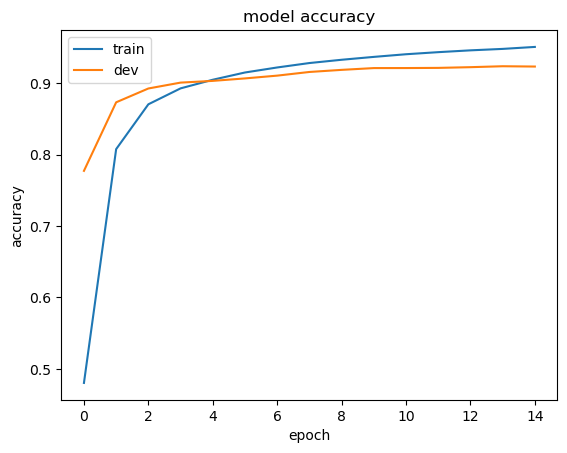

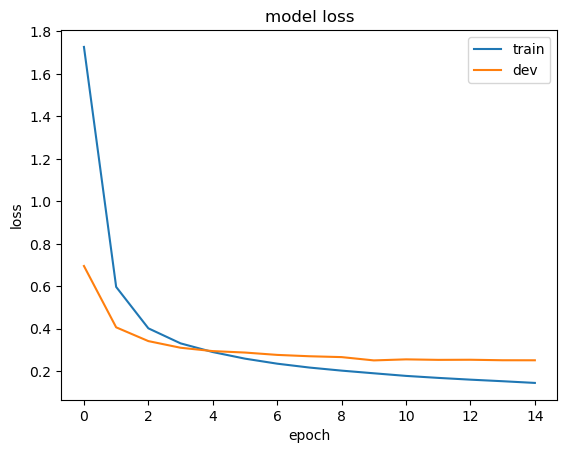

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

### DISPLAY CLASSIFICATION REPORT

In [31]:
# Create label names
label_names = [key for key in tag_tokenizer.word_index]
print(label_names)

['noun', 'punct', 'verb', 'pron', 'adp', 'det', 'adj', 'aux', 'propn', 'adv', 'cconj', 'part', 'num', 'sconj', 'sym', 'intj', 'x']


In [32]:
from sklearn.metrics import classification_report, precision_recall_curve, auc

def classification_reports(predictions_train, predictions_dev, predictions_test, y_train, y_dev, y_test, class_names):
    """
    Create a function for the classification report for the baseline model for all labels
    :param predictions_train: np.array
    :param predictions_dev: np.array
    :param predictions_test: np.array
    :param y_train: np.array
    :param y_dev: np.array
    :param y_test: np.array
    :param class_names: array of strings
    :return: null
    """

    y_true_train = []
    y_preds_train = []
    for i in range(len(y_train)):
      if y_train[i]>0:
        y_true_train.append(y_train[i])
        y_preds_train.append(predictions_train[i])
        
    y_true_dev = []
    y_preds_dev = []
    for i in range(len(y_dev)):
      if y_dev[i]>0:
        y_true_dev.append(y_dev[i])
        y_preds_dev.append(predictions_dev[i])
        
    y_true_test = []
    y_preds_test = []
    for i in range(len(y_test)):
      if y_test[i]>0:
        y_true_test.append(y_test[i])
        y_preds_test.append(predictions_test[i])
    classification_report_train = classification_report(y_true_train, y_preds_train, target_names=class_names,zero_division=0)

    classification_report_dev = classification_report(y_true_dev, y_preds_dev, target_names=class_names,zero_division=0)

    classification_report_test = classification_report(y_true_test, y_preds_test, target_names=class_names,zero_division=0)

    combined_cl_report = f'\n\t\tClassification report on Training Set: \n\n{classification_report_train}'
    combined_cl_report += f'\n\t\tClassification report on Development Set: \n\n{classification_report_dev}'
    combined_cl_report += f'\n\t\tClassification report on Testing Set: \n\n{classification_report_test}'

    print(combined_cl_report)

In [33]:
# In order to load the model from the weights file, we need the architecture
class_labels = train_pos.UPOS.unique()

# Predict training, developement, testing sets
predictions_train = np.argmax(LSTM_model.predict(np.array(X_train_final)), -1)
predictions_dev = np.argmax(LSTM_model.predict(np.array(X_dev_final)), -1)
predictions_test = np.argmax(LSTM_model.predict(np.array(X_test_final)), -1)



predictions_train = predictions_train.flatten()
predictions_dev =  predictions_dev.flatten()
predictions_test =  predictions_test.flatten()

# Provide classifcation reports
classification_reports(predictions_train, predictions_dev, predictions_test, y_train_final.flatten(), y_dev_final.flatten(), y_test_final.flatten(), class_names=class_labels)


65/65 [==============================] - 24s 369ms/step

		Classification report on Training Set: 

              precision    recall  f1-score   support

       PROPN       0.95      0.95      0.95     34787
       PUNCT       1.00      1.00      1.00     23579
         ADJ       0.96      0.97      0.97     22559
        NOUN       0.99      0.99      0.99     18646
        VERB       0.96      0.97      0.97     17778
         DET       0.99      0.99      0.99     16292
         ADP       0.93      0.92      0.93     13150
         AUX       0.99      0.99      0.99     12808
        PRON       0.91      0.90      0.90     12610
        PART       0.93      0.92      0.93     10103
       SCONJ       0.99      1.00      0.99      6682
         NUM       0.98      0.99      0.99      5747
         ADV       0.97      0.98      0.98      4126
       CCONJ       0.90      0.89      0.89      3816
        INTJ       0.91      0.91      0.91       721
           X       0.96      0.91  

In [34]:
# Predict probabilities for each set
model = LSTM_model

# Predict probabilities for train, dev, and test sets
train_probs = model.predict(np.array(X_train_final))
dev_probs = model.predict(np.array(X_dev_final))
test_probs = model.predict(np.array(X_test_final))

y_train = y_train_final
y_dev = y_dev_final
y_test = y_test_final

65/65 [==============================] - 24s 376ms/step


In [37]:
# Predict 
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def compute_pr_auc(y_true, y_pred):
    """
    :param y_true: np.array
    :param y_pred: np.array
    :return: pr auc scores for each class
    """
    num_classes = 17
    pr_auc_scores = {}
    

    for class_label in range(1,num_classes):
        y_train_binary = (y_true == class_label).astype(int)

        precision, recall, _ = precision_recall_curve(y_train_binary[:].flatten(), y_pred[:,:, class_label].flatten())
        pr_auc_scores[class_label] = auc(recall, precision)

    return pr_auc_scores


pr_auc_scores_train = compute_pr_auc(y_train, train_probs)
print("PR-AUC Scores for Each Class Train:")
for class_label, pr_auc in pr_auc_scores_train.items():
    print(f"Class {class_label}: {pr_auc:.3}")
mean_value = np.mean(list(pr_auc_scores_train.values()))
print(f'\n\nMacro-averaged Precision-Recall AUC on Training Set: {mean_value:.3}')

pr_auc_scores_dev = compute_pr_auc(y_dev, dev_probs)
print("\n\nPR-AUC Scores for Each Class Development:")
for class_label, pr_auc in pr_auc_scores_dev.items():
    print(f"Class {class_label}: {pr_auc:.3}")
mean_value = np.mean(list(pr_auc_scores_dev.values()))
print(f'\n\nMacro-averaged Precision-Recall AUC on Dev Set: {mean_value:.3}')
pr_auc_scores_test = compute_pr_auc(y_test, test_probs)
print("\n\nPR-AUC Scores for Each Class Test:")
for class_label, pr_auc in pr_auc_scores_test.items():
    print(f"Class {class_label}: {pr_auc:.3}")
mean_value = np.mean(list(pr_auc_scores_test.values()))
print(f'\n\nMacro-averaged Precision-Recall AUC on Test Set: {mean_value:.3}')

PR-AUC Scores for Each Class Train:
Class 1: 0.983
Class 2: 0.999
Class 3: 0.99
Class 4: 0.997
Class 5: 0.99
Class 6: 0.998
Class 7: 0.969
Class 8: 0.996
Class 9: 0.958
Class 10: 0.97
Class 11: 0.997
Class 12: 0.998
Class 13: 0.995
Class 14: 0.954
Class 15: 0.943
Class 16: 0.949


Macro-averaged Precision-Recall AUC on Training Set: 0.98


PR-AUC Scores for Each Class Development:
Class 1: 0.947
Class 2: 0.997
Class 3: 0.974
Class 4: 0.996
Class 5: 0.985
Class 6: 0.996
Class 7: 0.94
Class 8: 0.993
Class 9: 0.797
Class 10: 0.94
Class 11: 0.996
Class 12: 0.989
Class 13: 0.875
Class 14: 0.918
Class 15: 0.763
Class 16: 0.761


Macro-averaged Precision-Recall AUC on Dev Set: 0.929


PR-AUC Scores for Each Class Test:
Class 1: 0.944
Class 2: 0.997
Class 3: 0.975
Class 4: 0.994
Class 5: 0.987
Class 6: 0.997
Class 7: 0.935
Class 8: 0.995
Class 9: 0.816
Class 10: 0.949
Class 11: 0.995
Class 12: 0.995
Class 13: 0.829
Class 14: 0.92
Class 15: 0.851
Class 16: 0.866


Macro-averaged Precision-Recal

## EXAMPLE OF A RANDOM SENTENCE

In [38]:
# Example sentence
sentence = ['the cat sat in the mat']

# Get predictions for the test set
y_pred_exam = np.argmax(LSTM_model.predict(np.array(sentence)), axis=-1)

words = [tag_tokenizer.index_word[token] for token in y_pred_exam.flatten()]

print(sentence)
words[:6]

1/1 [==============================] - 0s 206ms/step
['the cat sat in the mat']


['det', 'noun', 'verb', 'adp', 'det', 'noun']

### COMMENTS

As we can see from the above results our model is very efficient and tagging the words very accurately.